In [53]:
import numpy as np
np.random.seed(19906)
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.preprocessing import image
import cv2
import os
import h5py
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import *
from keras.layers import *
from keras.layers.core import Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras.regularizers import l2
from keras.applications.inception_v3 import InceptionV3, preprocess_input as inceptionv3_preinput
from keras.applications.xception import Xception, preprocess_input as xception_preinput
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input as inception_resnet_preinput
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [54]:
train_dir = "data/imgs/train2"
val_dir = "data/imgs/val2"
test_dir = "data/imgs/test1"
saved_weights_dir = "saved_weights"

加载特征向量

In [55]:
def one_hot_encode(y):
    l = list()
    for item in y:
        c = [0. for i in range(10)]
        c[item] = 1.
        l.append(c)
    return np.array(l)

In [56]:
premodels = [
    "bottleneck_noaug_inception_v3.h5",
    "bottleneck_noaug_xception.h5",
    "bottleneck_noaug_inception_resnet_v2.h5"
]

X_train = []
X_valid = []

for filename in premodels:
    with h5py.File(os.path.join(saved_weights_dir, filename), "r") as h:
        X_train.append(np.array(h["train"]))
        X_valid.append(np.array(h["valid"]))
        y_train = np.array(h["label"])
        y_valid = np.array(h["valid_label"])
        
X_train = np.concatenate(X_train, axis=1)
X_valid = np.concatenate(X_valid, axis=1)

X_train, y_train = shuffle(X_train, y_train)
y_train = one_hot_encode(y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)
y_valid = one_hot_encode(y_valid)

In [57]:
print(X_train.shape)
print(y_train.shape)

(20741, 5632)
(20741, 10)


构建模型

In [58]:
input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5)(x)
x = Dense(10, activation='softmax')(x)
mix_model = Model(input_tensor, x)

op = Adam(lr=0.00001, decay=1e-8)
mix_model.compile(optimizer=op, loss='categorical_crossentropy', metrics=['accuracy'])

开始训练

In [59]:
epochs = 10
batch_size = 128

save_file = saved_weights_dir + '/mixed_model.h5'
print("Will save weight file:", save_file)
callbacks = [
    ModelCheckpoint(save_file, monitor="val_loss", mode="min", save_best_only=True, verbose=1, period=1)
]

history = mix_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid,y_valid), callbacks=callbacks)

Will save weight file: saved_weights/mixed_model.h5
Train on 20741 samples, validate on 1583 samples
Epoch 1/10
20741/20741 [==============================] - 1s 47us/step - loss: 1.8351 - acc: 0.4007 - val_loss: 0.7358 - val_acc: 0.9981

Epoch 00001: val_loss improved from inf to 0.73578, saving model to saved_weights/mixed_model.h5
Epoch 2/10
20741/20741 [==============================] - 1s 31us/step - loss: 0.5719 - acc: 0.9099 - val_loss: 0.2041 - val_acc: 1.0000

Epoch 00002: val_loss improved from 0.73578 to 0.20406, saving model to saved_weights/mixed_model.h5
Epoch 3/10
20741/20741 [==============================] - 1s 31us/step - loss: 0.2151 - acc: 0.9948 - val_loss: 0.0866 - val_acc: 1.0000

Epoch 00003: val_loss improved from 0.20406 to 0.08655, saving model to saved_weights/mixed_model.h5
Epoch 4/10
20741/20741 [==============================] - 1s 31us/step - loss: 0.1101 - acc: 0.9988 - val_loss: 0.0488 - val_acc: 1.0000

Epoch 00004: val_loss improved from 0.08655 to 0

绘制图型

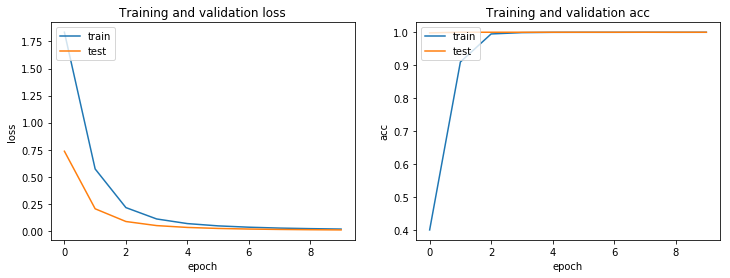

In [60]:
# 绘制图型
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Training and validation acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

开始预测

加载测试集特征向量

In [61]:
test_premodels = [
    "bottleneck_test_inception_v3.h5",
    "bottleneck_test_xception.h5",
    "bottleneck_test_inception_resnet_v2.h5"
]

X_test = []

for filename in test_premodels:
    with h5py.File(os.path.join(saved_weights_dir, filename), 'r') as h:
        X_test.append(np.array(h['test']))
        
X_test = np.concatenate(X_test, axis=1)

test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(test_dir, (299, 299), shuffle=False, 
                                         batch_size=128, class_mode=None)

Found 79726 images belonging to 1 classes.


预测并输出可提交kaggle的结果文件

In [62]:
sub_df = pd.read_csv("data/sample_submission.csv")

y_preds = mix_model.predict(X_test, verbose=1)
y_preds = y_preds.clip(min=0.005, max=0.995)
print("y_pred shape {}".format(y_preds.shape))

for i, fname in enumerate(test_generator.filenames):
    y_pred = y_preds[i]
    for k, c in enumerate(y_pred):
        sub_df.at[i, 'c'+str(k)] = c

print(sub_df.head())

sub_df.to_csv('data/mix_pred.csv', index=None)
print("predict done.")

79726/79726 [==============================] - 3s 40us/step
y_pred shape (79726, 10)
              img        c0     c1     c2        c3     c4        c5     c6  \
0       img_1.jpg  0.005000  0.005  0.005  0.005000  0.005  0.993731  0.005   
1      img_10.jpg  0.005000  0.005  0.005  0.005000  0.005  0.995000  0.005   
2     img_100.jpg  0.977879  0.005  0.005  0.005000  0.005  0.005000  0.005   
3    img_1000.jpg  0.005000  0.005  0.005  0.005000  0.005  0.005000  0.005   
4  img_100000.jpg  0.005000  0.005  0.005  0.991666  0.005  0.005000  0.005   

      c7        c8        c9  
0  0.005  0.005000  0.005000  
1  0.005  0.005000  0.005000  
2  0.005  0.005000  0.006303  
3  0.005  0.993114  0.005000  
4  0.005  0.005000  0.005000  
predict done.


提交Kaggle后得分：private: 0.23074, public: 0.26807